In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
from tqdm import tqdm
import multiprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_log_error

pd.set_option('display.max_columns', None)

In [2]:
def verify(df):
    print(df.shape)
    display(df.head())
    display(df.tail())

In [3]:
df = pd.read_csv('data/train_clean.csv')
verify(df)

(3008016, 6)


,index,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-02,1,AUTOMOTIVE,2.0,0
2,2,2013-01-03,1,AUTOMOTIVE,3.0,0
3,3,2013-01-04,1,AUTOMOTIVE,3.0,0
4,4,2013-01-05,1,AUTOMOTIVE,5.0,0


,index,date,store_nbr,family,sales,onpromotion
3008011,3008011,2017-08-11,9,SEAFOOD,23.831000,0
3008012,3008012,2017-08-12,9,SEAFOOD,16.859001,4
3008013,3008013,2017-08-13,9,SEAFOOD,20.000000,0
3008014,3008014,2017-08-14,9,SEAFOOD,17.000000,0
3008015,3008015,2017-08-15,9,SEAFOOD,16.000000,0


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df.nunique()

index          3008016
date              1688
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

In [6]:
df_total_sales = df.groupby("date").sales.sum().reset_index()
verify(df_total_sales)

(1688, 2)


,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


,date,sales
1683,2017-08-11,826373.722022
1684,2017-08-12,792630.535079
1685,2017-08-13,865639.677471
1686,2017-08-14,760922.406081
1687,2017-08-15,762661.935939


In [7]:
df_total_sales.describe()

,sales
count,1.688000e+03
mean,6.383662e+05
std,2.349880e+05
min,2.511619e+03
25%,4.431706e+05
50%,6.328329e+05
75%,7.866993e+05
max,1.463084e+06


In [8]:
df_total_sales['sales'].nsmallest()

0        2511.618999
365      8602.065404
1461    12082.500997
730     12773.616980
1095    16433.394000
Name: sales, dtype: float64

In [9]:
df_total_sales.sort_values('sales', ascending=True).head(7)

,date,sales
0,2013-01-01,2511.618999
365,2014-01-01,8602.065404
1461,2017-01-01,12082.500997
730,2015-01-01,12773.616980
1095,2016-01-01,16433.394000
23,2013-01-24,247245.690995
72,2013-03-14,247541.420096


In [10]:
df_model = df[df['date'] >= pd.to_datetime('2013-01-02')].drop(columns=['index']).reset_index(drop=True)
verify(df_model)

(3006234, 5)


,date,store_nbr,family,sales,onpromotion
0,2013-01-02,1,AUTOMOTIVE,2.0,0
1,2013-01-03,1,AUTOMOTIVE,3.0,0
2,2013-01-04,1,AUTOMOTIVE,3.0,0
3,2013-01-05,1,AUTOMOTIVE,5.0,0
4,2013-01-06,1,AUTOMOTIVE,2.0,0


,date,store_nbr,family,sales,onpromotion
3006229,2017-08-11,9,SEAFOOD,23.831000,0
3006230,2017-08-12,9,SEAFOOD,16.859001,4
3006231,2017-08-13,9,SEAFOOD,20.000000,0
3006232,2017-08-14,9,SEAFOOD,17.000000,0
3006233,2017-08-15,9,SEAFOOD,16.000000,0


# Experimento 0
## Target = Total Sales

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1672
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -21739.335
Date:                           Mon, 13 Mar 2023   AIC                          43488.671
Time:                                   16:06:15   BIC                          43515.753
Sample:                                        0   HQIC                         43498.708
                                          - 1672                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8234      0.044     18.631      0.000       0.737       0.910
ma.L1         -0.3995      0.043     -9.264

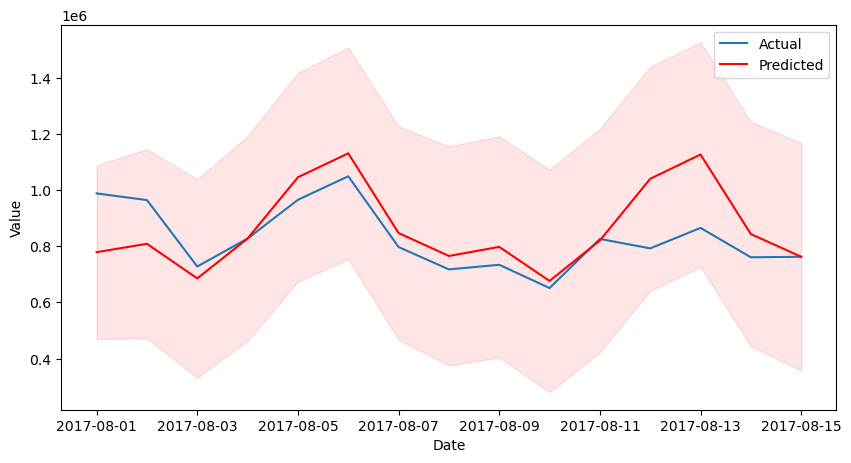

RMSLE Sum Sales: 0.13513535855283226


In [32]:
df_model = df[df['date'] >= pd.to_datetime('2013-01-02')].drop(columns=['index']).reset_index(drop=True)

df_total_sales = df_model.groupby("date").sales.sum().reset_index()

dates = df_total_sales.date.tolist()

df_total_sales_train = df_total_sales.iloc[:-15]
df_total_sales_test = df_total_sales.iloc[-15:]

train_data = df_total_sales_train['sales']
valid_data = df_total_sales_test['sales']

model = sm.tsa.statespace.SARIMAX(train_data, order=(1,0,1), seasonal_order=(1,0,1,7), 
                              enforce_invertibility=False, enforce_stationarity=False)
results = model.fit(disp=False)
print(results.summary())

preds = results.get_prediction(start=valid_data.index[0], end=valid_data.index[-1])
pred_means = preds.predicted_mean
pred_ci = preds.conf_int()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_total_sales_test.date, valid_data.values, label="Actual")
ax.plot(df_total_sales_test.date, pred_means.values, label="Predicted", color="red")
ax.fill_between(df_total_sales_test.date, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="red", alpha=0.1)
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend()
plt.show()

print("RMSLE Sum Sales:", mean_squared_log_error(valid_data, pred_means, squared=False))

# Experimento 1
## Target = Total Sales, Proporção Family/Store

- A lógica aqui foi ajustar um SARIMA na soma das vendas totais. Para ter a predição em cada loja/família de itens, foi tomada a proporção média diária em relação ao número total de vendas na base de treino para cada loja/família de itens.
- Foi usada uma base de teste com duração de 15 dias pois a base de submissão do Kaggle tinha essa duração. Portanto, foi admitido no processo de modelagem que o objetivo era ter o melhor forecast possível para um intervalo de 15 dias a frente.

                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                 1672
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -21739.335
Date:                           Mon, 13 Mar 2023   AIC                          43488.671
Time:                                   11:32:17   BIC                          43515.753
Sample:                                        0   HQIC                         43498.708
                                          - 1672                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8234      0.044     18.631      0.000       0.737       0.910
ma.L1         -0.3995      0.043     -9.264

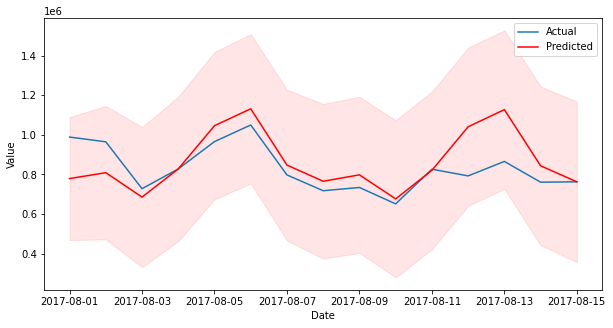

RMSLE Sum Sales: 0.13513535961303796
RMSLE for each family/store: 0.7265496189888384


In [16]:
df_model = df[df['date'] >= pd.to_datetime('2013-01-02')].drop(columns=['index']).reset_index(drop=True)

df_total_sales = df_model.groupby("date").sales.sum().reset_index()

dates = df_total_sales.date.tolist()

df_total_sales_train = df_total_sales.iloc[:-15]
df_total_sales_test = df_total_sales.iloc[-15:]

df_train = df_model[df_model['date'].isin(df_total_sales_train.date.unique())]
df_test = df_model[df_model['date'].isin(df_total_sales_test.date.unique())]

df_proportion_train = df_train.drop(columns=['onpromotion'])
df_proportion_train = df_proportion_train.merge(df_total_sales_train, on='date', how='inner')
df_proportion_train.rename(columns={'sales_x': 'sales_family_store', 'sales_y': 'total_sales'}, inplace=True)
df_proportion_train['proportion'] = df_proportion_train['sales_family_store'] / df_proportion_train['total_sales']
df_proportion_train = df_proportion_train.groupby(['store_nbr', 'family'])['proportion'].mean().reset_index()

train_data = df_total_sales_train['sales']
valid_data = df_total_sales_test['sales']

model = sm.tsa.statespace.SARIMAX(train_data, order=(1,0,1), seasonal_order=(1,0,1,7), 
                              enforce_invertibility=False, enforce_stationarity=False)
results = model.fit()
print(results.summary())

preds = results.get_prediction(start=valid_data.index[0], end=valid_data.index[-1])
pred_means = preds.predicted_mean
pred_ci = preds.conf_int()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_total_sales_test.date, valid_data.values, label="Actual")
ax.plot(df_total_sales_test.date, pred_means.values, label="Predicted", color="red")
ax.fill_between(df_total_sales_test.date, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="red", alpha=0.1)
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend()
plt.show()

df_total_sales_test['pred_total_sales'] = pred_means
df_test = df_test.merge(df_total_sales_test[['date', 'pred_total_sales']], on='date', how='inner')
df_test = df_test.merge(df_proportion_train, on=['store_nbr', 'family'], how='inner')
df_test['pred_sales'] = df_test['proportion'] * df_test['pred_total_sales']

rmsle_total_sales = mean_squared_log_error(valid_data, pred_means, squared=False)
print("RMSLE Sum Sales:", rmsle_total_sales)
rmsle_sales = mean_squared_log_error(df_test.sales, df_test.pred_sales, squared=False)
print("RMSLE for each family/store:", mean_squared_log_error(df_test.sales, df_test.pred_sales, squared=False))

# Experimento 2
## Target = Total Sales, Proporção Family/Store, 24 folds CV

- Nesse teste, temos um resultado mais robusto na base de validação por usar o Cross-Validation.
- Dessa maneira, usando 24 folds de 15 dias cada, podemos avaliar a performance ao longo do ano do modelo.

In [17]:
df_model = df[df['date'] >= pd.to_datetime('2013-01-02')].drop(columns=['index']).reset_index(drop=True)

df_total_sales = df_model.groupby("date").sales.sum().reset_index()

dates = df_total_sales.date.tolist()

dict_results_CV = {'Fold': [],
                   'Start Test': [],
                   'End Test': [],
                   'RMSLE Total Sales': [],
                   'RMSLE Sales Family/Store': [],
                   'Execution Time': []}

tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(df_total_sales))):
    ini = time.time()
    
    df_total_sales_train = df_total_sales.iloc[train_index]
    df_total_sales_test = df_total_sales.iloc[test_index]
    
    df_train = df_model[df_model['date'].isin(df_total_sales_train.date.unique())]
    df_test = df_model[df_model['date'].isin(df_total_sales_test.date.unique())]
    
    df_proportion_train = df_train.drop(columns=['onpromotion'])
    df_proportion_train = df_proportion_train.merge(df_total_sales_train, on='date', how='inner')
    df_proportion_train.rename(columns={'sales_x': 'sales_family_store', 'sales_y': 'total_sales'}, inplace=True)
    df_proportion_train['proportion'] = df_proportion_train['sales_family_store'] / df_proportion_train['total_sales']
    df_proportion_train = df_proportion_train.groupby(['store_nbr', 'family'])['proportion'].mean().reset_index()
    
    train_data = df_total_sales_train['sales']
    valid_data = df_total_sales_test['sales']
    
    model = sm.tsa.statespace.SARIMAX(train_data, order=(1,0,1), seasonal_order=(1,0,1,7), 
                                  enforce_invertibility=False, enforce_stationarity=False)
    results = model.fit()
    
    preds = results.get_prediction(start=valid_data.index[0], end=valid_data.index[-1])
    pred_means = preds.predicted_mean
    pred_ci = preds.conf_int()
    rmsle_total_sales = mean_squared_log_error(valid_data, pred_means, squared=False)
    
    df_total_sales_test['pred_total_sales'] = pred_means
    df_test = df_test.merge(df_total_sales_test[['date', 'pred_total_sales']], on='date', how='inner')
    df_test = df_test.merge(df_proportion_train, on=['store_nbr', 'family'], how='inner')
    df_test['pred_sales'] = df_test['proportion'] * df_test['pred_total_sales']
    rmsle_sales = mean_squared_log_error(df_test.sales, df_test.pred_sales, squared=False)
    
    fim = time.time()
    
    dict_results_CV['Fold'].append(i)
    dict_results_CV['Start Test'].append(df_test.date.min())
    dict_results_CV['End Test'].append(df_test.date.max())
    dict_results_CV['RMSLE Total Sales'].append(rmsle_total_sales)
    dict_results_CV['RMSLE Sales Family/Store'].append(rmsle_sales)
    dict_results_CV['Execution Time'].append(fim-ini)

24it [00:44,  1.84s/it]


In [18]:
df_results_CV = pd.DataFrame(dict_results_CV)
display(df_results_CV)

,Fold,Start Test,End Test,RMSLE Total Sales,RMSLE Sales Family/Store,Execution Time
0,0,2016-08-21,2016-09-04,0.115110,1.047069,1.724188
1,1,2016-09-05,2016-09-19,0.110143,1.065850,1.685580
2,2,2016-09-20,2016-10-04,0.124085,1.025429,1.964189
3,3,2016-10-05,2016-10-19,0.063743,1.036087,1.726893
4,4,2016-10-20,2016-11-03,0.152866,0.949435,1.551893
5,5,2016-11-04,2016-11-18,0.067325,0.899398,1.584685
6,6,2016-11-19,2016-12-03,0.109405,0.840110,1.621918
7,7,2016-12-04,2016-12-18,0.091500,0.670356,1.609079
8,8,2016-12-19,2017-01-02,1.212853,1.407911,1.644196
9,9,2017-01-03,2017-01-17,0.170716,0.659621,1.641416


In [19]:
df_results_CV.describe()

,Fold,RMSLE Total Sales,RMSLE Sales Family/Store,Execution Time
count,24.000000,24.000000,24.000000,24.000000
mean,11.500000,0.154292,0.816764,1.841496
std,7.071068,0.227475,0.192249,0.249591
min,0.000000,0.051192,0.612632,1.551893
25%,5.750000,0.091177,0.691225,1.667586
50%,11.500000,0.109687,0.722347,1.736081
75%,17.250000,0.136307,0.932011,1.983416
max,23.000000,1.212853,1.407911,2.546082


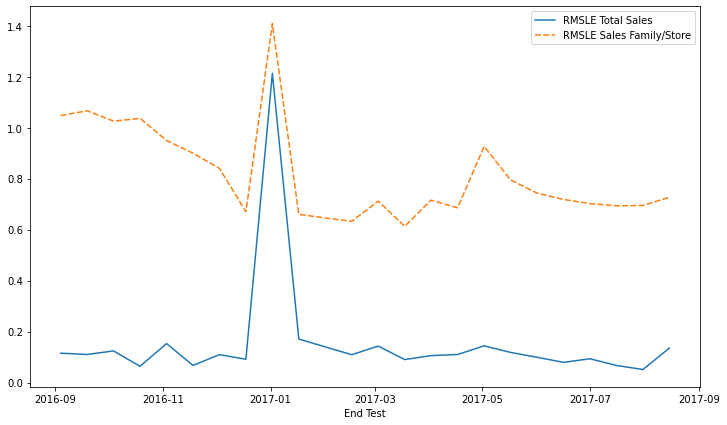

In [20]:
fig, (ax1) = plt.subplots(1,1,figsize=(12, 7))
sns.lineplot(data=df_results_CV[['End Test', 'RMSLE Total Sales', 'RMSLE Sales Family/Store']].set_index('End Test'), ax=ax1)
plt.show()

# Experimento 3
## Target = Total Sales, Proporção Family/Store, 24 folds CV, Otimiza order SARIMA

In [23]:
orders = []
for p in reversed(list(range(1, 7))):
    for q in reversed(list(range(1, 7))):
        orders.append((p, 0, q))
print(len(orders))
orders

36


[(6, 0, 6),
 (6, 0, 5),
 (6, 0, 4),
 (6, 0, 3),
 (6, 0, 2),
 (6, 0, 1),
 (5, 0, 6),
 (5, 0, 5),
 (5, 0, 4),
 (5, 0, 3),
 (5, 0, 2),
 (5, 0, 1),
 (4, 0, 6),
 (4, 0, 5),
 (4, 0, 4),
 (4, 0, 3),
 (4, 0, 2),
 (4, 0, 1),
 (3, 0, 6),
 (3, 0, 5),
 (3, 0, 4),
 (3, 0, 3),
 (3, 0, 2),
 (3, 0, 1),
 (2, 0, 6),
 (2, 0, 5),
 (2, 0, 4),
 (2, 0, 3),
 (2, 0, 2),
 (2, 0, 1),
 (1, 0, 6),
 (1, 0, 5),
 (1, 0, 4),
 (1, 0, 3),
 (1, 0, 2),
 (1, 0, 1)]

In [31]:
df_model = df[df['date'] >= pd.to_datetime('2013-01-02')].drop(columns=['index']).reset_index(drop=True)

df_total_sales = df_model.groupby("date").sales.sum().reset_index()

dates = df_total_sales.date.tolist()

dict_results_CV = {'Order p': [],
                   'Order q': [],  
                   'Fold': [],
                   'Start Test': [],
                   'End Test': [],
                   'RMSLE Total Sales': [],
                   'RMSLE Sales Family/Store': [],
                   'Execution Time': []}

for order in tqdm(orders):
    tscv = TimeSeriesSplit(n_splits=24, test_size=15)
    for i, (train_index, test_index) in enumerate(tscv.split(df_total_sales)):
        ini = time.time()

        df_total_sales_train = df_total_sales.iloc[train_index]
        df_total_sales_test = df_total_sales.iloc[test_index]

        df_train = df_model[df_model['date'].isin(df_total_sales_train.date.unique())]
        df_test = df_model[df_model['date'].isin(df_total_sales_test.date.unique())]

        df_proportion_train = df_train.drop(columns=['onpromotion'])
        df_proportion_train = df_proportion_train.merge(df_total_sales_train, on='date', how='inner')
        df_proportion_train.rename(columns={'sales_x': 'sales_family_store', 'sales_y': 'total_sales'}, inplace=True)
        df_proportion_train['proportion'] = df_proportion_train['sales_family_store'] / df_proportion_train['total_sales']
        df_proportion_train = df_proportion_train.groupby(['store_nbr', 'family'])['proportion'].mean().reset_index()

        train_data = df_total_sales_train['sales']
        valid_data = df_total_sales_test['sales']

        model = sm.tsa.statespace.SARIMAX(train_data, order=order, seasonal_order=(1,0,1,7), 
                                      enforce_invertibility=False, enforce_stationarity=False)
        results = model.fit()

        preds = results.get_prediction(start=valid_data.index[0], end=valid_data.index[-1])
        pred_means = preds.predicted_mean
        pred_means = pred_means.apply(lambda x: np.max([0, x]))
        pred_ci = preds.conf_int()
        rmsle_total_sales = mean_squared_log_error(valid_data, pred_means, squared=False)

        df_total_sales_test['pred_total_sales'] = pred_means
        df_test = df_test.merge(df_total_sales_test[['date', 'pred_total_sales']], on='date', how='inner')
        df_test = df_test.merge(df_proportion_train, on=['store_nbr', 'family'], how='inner')
        df_test['pred_sales'] = df_test['proportion'] * df_test['pred_total_sales']
        rmsle_sales = mean_squared_log_error(df_test.sales, df_test.pred_sales, squared=False)

        fim = time.time()
        
        dict_results_CV['Order p'].append(order[0])
        dict_results_CV['Order q'].append(order[2])
        dict_results_CV['Fold'].append(i)
        dict_results_CV['Start Test'].append(df_test.date.min())
        dict_results_CV['End Test'].append(df_test.date.max())
        dict_results_CV['RMSLE Total Sales'].append(rmsle_total_sales)
        dict_results_CV['RMSLE Sales Family/Store'].append(rmsle_sales)
        dict_results_CV['Execution Time'].append(fim-ini)

  0%|          | 0/36 [00:00<?, ?it/s]C:\Users\gduar\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gduar\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gduar\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gduar\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\gduar\anaconda3\lib\site-packages\statsmodels\base\mo

In [32]:
df_results_CV = pd.DataFrame(dict_results_CV)
df_results_CV

,Order p,Order q,Fold,Start Test,End Test,RMSLE Total Sales,RMSLE Sales Family/Store,Execution Time
0,6,6,0,2016-08-21,2016-09-04,0.109693,1.047537,5.490403
1,6,6,1,2016-09-05,2016-09-19,0.108363,1.065554,5.595278
2,6,6,2,2016-09-20,2016-10-04,0.122711,1.027186,6.912256
3,6,6,3,2016-10-05,2016-10-19,0.076402,1.039096,5.591039
4,6,6,4,2016-10-20,2016-11-03,0.147691,0.948907,6.246943
...,...,...,...,...,...,...,...,...
859,1,1,19,2017-06-02,2017-06-16,0.079300,0.718144,1.897854
860,1,1,20,2017-06-17,2017-07-01,0.093361,0.701641,1.942291
861,1,1,21,2017-07-02,2017-07-16,0.067102,0.693171,1.921400
862,1,1,22,2017-07-17,2017-07-31,0.051192,0.694604,2.020689


In [33]:
df_results_CV.to_csv('data_results/SARIMA_TotalSales_24folds_GridSearchOrder.csv', index=False)

In [34]:
df_results_CV.groupby(['Order p', 'Order q']).agg({'RMSLE Sales Family/Store': ['min', 'median', 'max', 'mean', 'std']})

RMSLE Sales Family/Store                                 \
                                     min    median        max      mean   
Order p Order q                                                           
1       1                       0.612632  0.722347   1.407911  0.816764   
        2                       0.612793  0.722338   1.407539  0.816711   
        3                       0.610163  0.722031   1.407619  0.817113   
        4                       0.613180  0.722385   1.407678  0.816744   
        5                       0.614170  0.722513   1.407225  0.817033   
        6                       0.614124  0.722504   1.407146  0.817056   
2       1                       0.612476  0.722527  45.910807  5.168964   
        2                       0.613195  0.722407   1.407495  0.816755   
        3                       0.613141  0.722405   1.407533  0.817023   
        4                       0.613033  0.722401   1.407696  0.816677   
        5                       0.614028  0.722565   1.407308  0.816920   
        6                       0.613858  0.722538   1.407288  0.817263   
3       1                       0.613140  0.722351   1.407640  0.816755   
        2                       0.610237  0.722189   1.413021  0.816285   
        3                       0.612367  0.721975   1.408994  0.817024   
        4                       0.613039  0.722347   1.408024  0.816930   
        5                       0.613060  0.722344   1.407960  0.816989   
        6                       0.613220  0.722329   1.408053  0.816971   
4       1                       0.613329  0.722376   1.407617  0.816820   
        2                       0.620595  3.759919  11.328121  4.081366   
        3                       0.612454  0.722349   1.408275  0.816976   
        4                       0.613872  0.722492   1.408055  0.817149   
        5                       0.613250  0.722411   1.407278  0.817571   
        6                       0.612821  0.722118   1.406960  0.817144   
5       1                       0.614005  0.722474   1.407464  0.816939   
        2                       0.617139  0.734743   1.775674  0.863785   
        3                       0.612311  0.722071   1.408177  0.817105   
        4                       0.612431  0.722125   1.407784  0.816878   
        5                       0.612660  0.722044   1.408196  0.816842   
        6                       0.613457  0.722020   1.407628  0.816646   
6       1                       0.613923  0.722459   1.407473  0.816952   
        2                       0.613513  0.722431   1.407488  0.816831   
        3                       0.612804  0.722325   1.407632  0.817069   
        4                       0.613009  0.722310   1.408142  0.816790   
        5                       0.613868  0.722445   1.407744  0.817192   
        6                       0.616284  0.723122   1.406948  0.817067   

                            
                       std  
Order p Order q             
1       1         0.192249  
        2         0.192453  
        3         0.192206  
        4         0.192364  
        5         0.192309  
        6         0.192312  
2       1        12.078713  
        2         0.192475  
        3         0.192253  
        4         0.192467  
        5         0.192432  
        6         0.192144  
3       1         0.192360  
        2         0.191724  
        3         0.191621  
        4         0.192501  
        5         0.192536  
        6         0.192454  
4       1         0.192370  
        2         3.066237  
        3         0.191872  
        4         0.192679  
        5         0.191762  
        6         0.191336  
5       1         0.192474  
        2         0.268671  
        3         0.192198  
        4         0.191798  
        5         0.192098  
        6         0.192105  
6       1         0.192384  
        2         0.192395  
        3         0.192269  
        4         0.192571  
        5        

- A ideia aqui foi encontrar os melhores hiperparâmetros para o SARIMA (nesse caso, ordens p e q).
- A EDA mostrou que existia um ciclo semanal nas vendas e que existia alta correlação entre um ponto da série temporal e seus lags de 1 a 6.
- O resultado foi o de que ordens diferentes de (1,0,1) não melhoraram o resultado do RMSLE e apenas aumentaram o tempo de execução.

# Experimento 4
## 1 SARIMA for each Family/Store, 24 folds CV

- Nesse modelo, ao invés de ajustar apenas um SARIMA em cima das vendas totais, foi ajustado um modelo para cada combinação family/store.

In [11]:
def process_store_family(comb):
    
    store, family = comb[0], comb[1]
    df_item = df_model[(df_model['store_nbr'] == store) & (df_model['family'] == family)].reset_index(drop=True)
    
    result_folds = []
    
    tscv = TimeSeriesSplit(n_splits=24, test_size=15)
    for fold, (train_index, test_index) in enumerate(tscv.split(df_item)):
        
        df_train = df_item.iloc[train_index]
        df_test = df_item.iloc[test_index]
        
        start_date, end_date = df_test.date.min(), df_test.date.max()
        
        train_data = df_train['sales']
        valid_data = df_test['sales']
        
        model = sm.tsa.statespace.SARIMAX(train_data, order=(1,0,1), seasonal_order=(1,0,1,7), 
                                      enforce_invertibility=False, enforce_stationarity=False)
        results = model.fit(disp=False)
        
        preds = results.get_prediction(start=valid_data.index[0], end=valid_data.index[-1])
        pred_means = preds.predicted_mean
        pred_means = pred_means.apply(lambda x: np.max([0, x]))
        pred_means = list(pred_means)
        pred_ci = preds.conf_int()
        
        for idx in range(len(pred_means)):
            result_folds.append([store, family, fold, start_date, end_date, idx, pred_means[idx]])
            
    return result_folds

def parallel_SARIMA(input_list):
    with multiprocessing.Pool(processes=4) as pool:
        training_results = []
        for sub_result in tqdm(pool.imap_unordered(process_store_family, input_list), total=len(input_list)):
            training_results += sub_result

    return training_results

In [12]:
combinations = []
for store in df_model.store_nbr.unique():
    for family in df_model.family.unique():
        combinations.append((store, family))
print(len(combinations))
random_numbers = np.random.choice(list(range(len(combinations))), 5)
for i in random_numbers:
    print(combinations[i])

1782
(40, 'MAGAZINES')
(15, 'SCHOOL AND OFFICE SUPPLIES')
(17, 'MAGAZINES')
(48, 'DAIRY')
(24, 'PERSONAL CARE')


In [13]:
random_numbers = np.random.choice(list(range(len(combinations))), 16)
comb_subset = []
for i in random_numbers:
    comb_subset.append(combinations[i])
comb_subset

[(45, 'DAIRY'),
 (21, 'HOME CARE'),
 (23, 'PRODUCE'),
 (31, 'BABY CARE'),
 (24, 'DAIRY'),
 (9, 'LINGERIE'),
 (11, 'HOME APPLIANCES'),
 (22, 'LADIESWEAR'),
 (13, 'BOOKS'),
 (33, 'LADIESWEAR'),
 (36, 'SEAFOOD'),
 (16, 'HOME AND KITCHEN II'),
 (41, 'SCHOOL AND OFFICE SUPPLIES'),
 (19, 'HOME AND KITCHEN II'),
 (26, 'PREPARED FOODS'),
 (21, 'LINGERIE')]

In [14]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [15]:
results = parallel_SARIMA(combinations)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1782/1782 [9:44:37<00:00, 19.68s/it]


In [16]:
df_results = pd.DataFrame(results, columns=['Store', 'Family', 'Fold', 'Start Test', 'End Test', 
                                            'Index Pred', 'Pred'])
df_results

,Store,Family,Fold,Start Test,End Test,Index Pred,Pred
0,1,BABY CARE,0,2016-08-21,2016-09-04,0,0.000000
1,1,BABY CARE,0,2016-08-21,2016-09-04,1,0.000000
2,1,BABY CARE,0,2016-08-21,2016-09-04,2,0.000000
3,1,BABY CARE,0,2016-08-21,2016-09-04,3,0.000000
4,1,BABY CARE,0,2016-08-21,2016-09-04,4,0.000000
...,...,...,...,...,...,...,...
641515,9,SEAFOOD,23,2017-08-01,2017-08-15,10,13.249271
641516,9,SEAFOOD,23,2017-08-01,2017-08-15,11,23.091278
641517,9,SEAFOOD,23,2017-08-01,2017-08-15,12,22.485416
641518,9,SEAFOOD,23,2017-08-01,2017-08-15,13,14.333016


In [17]:
df_results.to_csv('data_results/SARIMA_StoreFamily_24folds.csv', index=False)

In [13]:
df_results = pd.read_csv('data_results/SARIMA_StoreFamily_24folds.csv')
df_results['Start Test'] = pd.to_datetime(df_results['Start Test'])
df_results['End Test'] = pd.to_datetime(df_results['End Test'])
df_results['date'] = df_results['Start Test'] + pd.to_timedelta(df_results['Index Pred'], unit='D')
df_results.rename(columns={'Store': 'store_nbr',
                           'Family': 'family'}, inplace=True)
df_results

,store_nbr,family,Fold,Start Test,End Test,Index Pred,Pred,date
0,1,BABY CARE,0,2016-08-21,2016-09-04,0,0.000000,2016-08-21
1,1,BABY CARE,0,2016-08-21,2016-09-04,1,0.000000,2016-08-22
2,1,BABY CARE,0,2016-08-21,2016-09-04,2,0.000000,2016-08-23
3,1,BABY CARE,0,2016-08-21,2016-09-04,3,0.000000,2016-08-24
4,1,BABY CARE,0,2016-08-21,2016-09-04,4,0.000000,2016-08-25
...,...,...,...,...,...,...,...,...
641515,9,SEAFOOD,23,2017-08-01,2017-08-15,10,13.249271,2017-08-11
641516,9,SEAFOOD,23,2017-08-01,2017-08-15,11,23.091278,2017-08-12
641517,9,SEAFOOD,23,2017-08-01,2017-08-15,12,22.485416,2017-08-13
641518,9,SEAFOOD,23,2017-08-01,2017-08-15,13,14.333016,2017-08-14


In [14]:
df_results = df_results.merge(df[['date', 'store_nbr', 'family', 'sales']],
                              on=['date', 'store_nbr', 'family'], how='left')
df_results

,store_nbr,family,Fold,Start Test,End Test,Index Pred,Pred,date,sales
0,1,BABY CARE,0,2016-08-21,2016-09-04,0,0.000000,2016-08-21,0.000000
1,1,BABY CARE,0,2016-08-21,2016-09-04,1,0.000000,2016-08-22,0.000000
2,1,BABY CARE,0,2016-08-21,2016-09-04,2,0.000000,2016-08-23,0.000000
3,1,BABY CARE,0,2016-08-21,2016-09-04,3,0.000000,2016-08-24,0.000000
4,1,BABY CARE,0,2016-08-21,2016-09-04,4,0.000000,2016-08-25,0.000000
...,...,...,...,...,...,...,...,...,...
641515,9,SEAFOOD,23,2017-08-01,2017-08-15,10,13.249271,2017-08-11,23.831000
641516,9,SEAFOOD,23,2017-08-01,2017-08-15,11,23.091278,2017-08-12,16.859001
641517,9,SEAFOOD,23,2017-08-01,2017-08-15,12,22.485416,2017-08-13,20.000000
641518,9,SEAFOOD,23,2017-08-01,2017-08-15,13,14.333016,2017-08-14,17.000000


In [22]:
df_evaluation = df_results.copy()

df_evaluation['True+1'] = df_evaluation['sales'] + 1
df_evaluation['Pred+1'] = df_evaluation['Pred'] + 1
df_evaluation['Log True'] = np.log(df_evaluation['True+1'])
df_evaluation['Log Pred'] = np.log(df_evaluation['Pred+1'])
df_evaluation['Diff Squared'] = (df_evaluation['Log Pred'] - df_evaluation['Log True']) ** 2
df_evaluation = df_evaluation.groupby(['Fold'])['Diff Squared'].sum().reset_index()
df_evaluation['Mean'] = df_evaluation['Diff Squared'] / (54 * 33 * 15)
df_evaluation['RMSLE'] = np.sqrt(df_evaluation['Mean'])
df_evaluation

,Fold,Diff Squared,Mean,RMSLE
0,0,18733.603090,0.700846,0.837165
1,1,16209.514248,0.606417,0.778728
2,2,13654.345953,0.510825,0.714720
3,3,12939.310291,0.484074,0.695755
4,4,11330.286287,0.423879,0.651060
5,5,9937.428975,0.371771,0.609730
6,6,7616.155042,0.284929,0.533788
7,7,6880.852362,0.257421,0.507366
8,8,45247.527553,1.692762,1.301062
9,9,6402.525094,0.239526,0.489414


In [24]:
df_evaluation.describe()

,Fold,Diff Squared,Mean,RMSLE
count,24.000000,24.000000,24.000000,24.000000
mean,11.500000,10045.261413,0.375805,0.580451
std,7.071068,8608.835582,0.322066,0.201426
min,0.000000,4368.202579,0.163419,0.404252
25%,5.750000,5147.857321,0.192587,0.438828
50%,11.500000,6658.507894,0.249102,0.499032
75%,17.250000,11732.542288,0.438928,0.662234
max,23.000000,45247.527553,1.692762,1.301062


In [25]:
df_evaluation = df_evaluation.merge(df_results[['Fold', 'End Test']].drop_duplicates(),
                                    on='Fold', how='inner')
df_evaluation

,Fold,Diff Squared,Mean,RMSLE,End Test
0,0,18733.603090,0.700846,0.837165,2016-09-04
1,1,16209.514248,0.606417,0.778728,2016-09-19
2,2,13654.345953,0.510825,0.714720,2016-10-04
3,3,12939.310291,0.484074,0.695755,2016-10-19
4,4,11330.286287,0.423879,0.651060,2016-11-03
5,5,9937.428975,0.371771,0.609730,2016-11-18
6,6,7616.155042,0.284929,0.533788,2016-12-03
7,7,6880.852362,0.257421,0.507366,2016-12-18
8,8,45247.527553,1.692762,1.301062,2017-01-02
9,9,6402.525094,0.239526,0.489414,2017-01-17


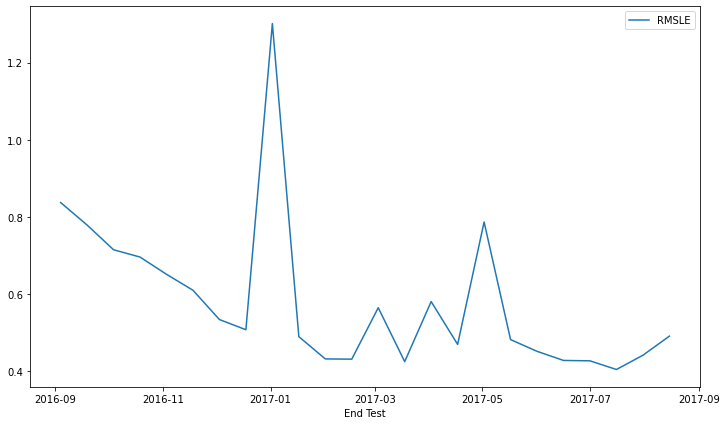

In [26]:
fig, (ax1) = plt.subplots(1,1,figsize=(12, 7))
sns.lineplot(data=df_evaluation[['End Test', 'RMSLE']].set_index('End Test'), ax=ax1)
plt.show()

- Apesar do aumento considerável de tempo para ajustar os modelos, foram obtidos ganhos consideráveis também na avaliação do RMSLE no cross-validation.
- A média caiu de 0.816764 para 0.580451 e a mediana caiu de 0.722347 para 0.499032